In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble as ske

from pprint import pprint
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

In [35]:
root_path = '/content/drive/MyDrive/MGC/Data'  

In [36]:
!ls /content/drive/MyDrive/MGC/Data

features_30_sec.csv  features_3_sec.csv  genres_original  images_original


In [37]:
df = pd.read_csv('/content/drive/MyDrive/MGC/Data/features_3_sec.csv')
df = df.drop(['harmony_mean','harmony_var'], axis = 1)
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [38]:
print("Dataset has",df.shape)
df.label.value_counts().reset_index()

Dataset has (9990, 58)


,index,label
0,reggae,1000
1,metal,1000
2,pop,1000
3,blues,1000
4,jazz,1000
5,disco,999
6,hiphop,998
7,rock,998
8,classical,998
9,country,997


In [39]:
audio_fp = '/content/drive/MyDrive/MGC/Data/genres_original/classical/classical.00000.wav'
audio_data, sr = librosa.load(audio_fp, offset=0, duration=30)
audio_data, _ = librosa.effects.trim(audio_data)
audio_data.shape

(661500,)

In [40]:
collection = np.split(audio_data,10)

In [41]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

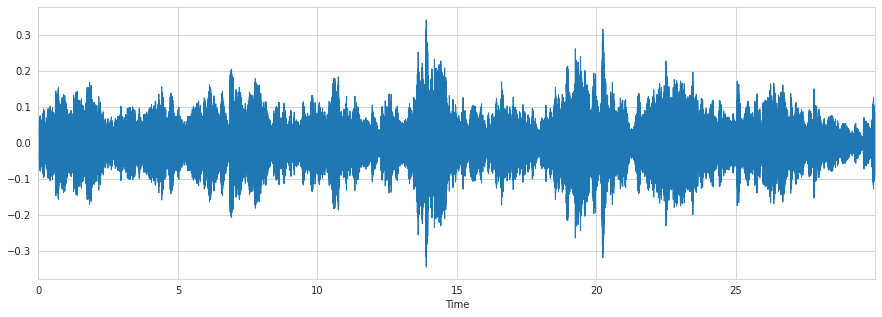

In [42]:
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()


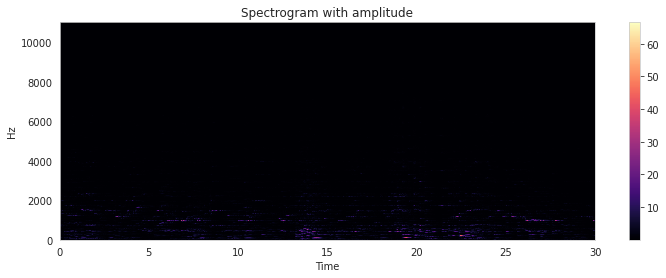

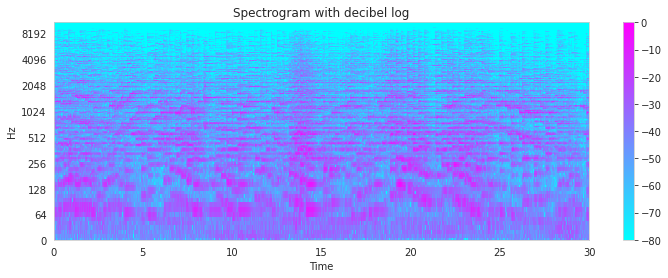

In [43]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

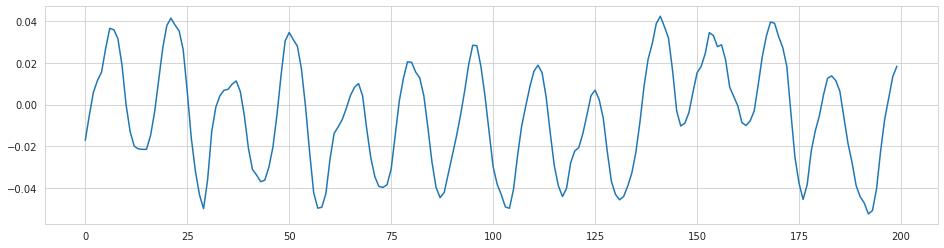

In [44]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

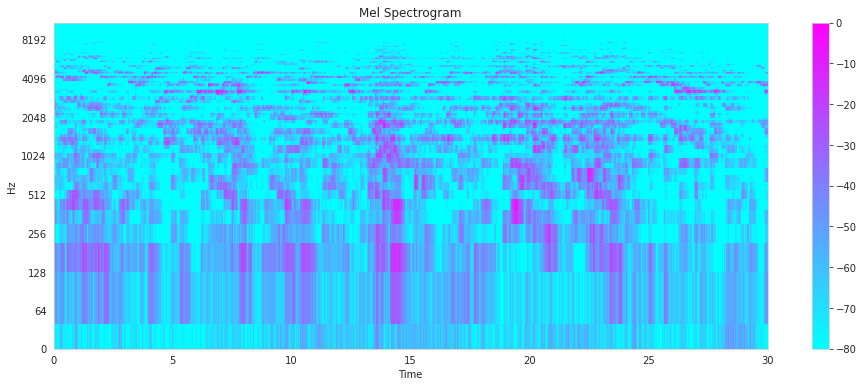

In [45]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

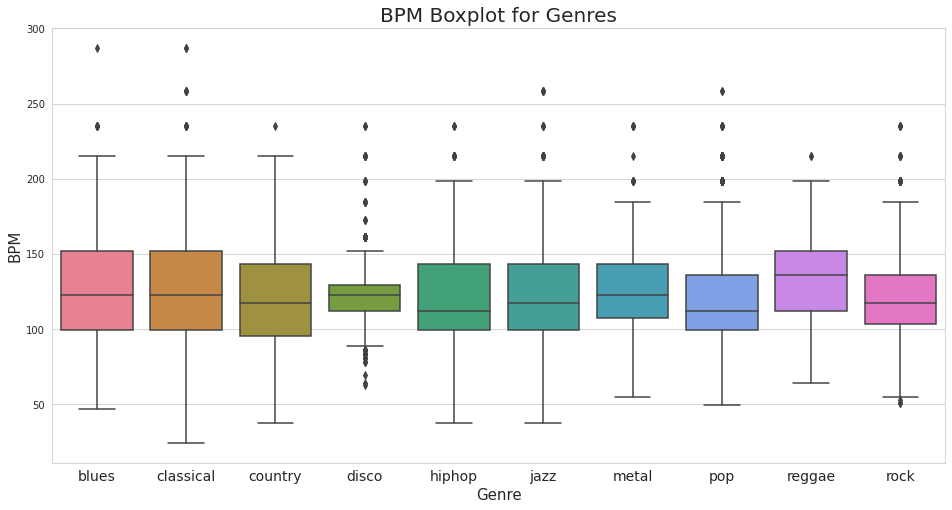

In [46]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

In [47]:
  data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# # Top 2 pca components
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(X)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# # concatenate with target label
# finalDf = pd.concat([principalDf, y], axis = 1)

# plt.figure(figsize = (16, 9))
# sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

# plt.title('PCA on Genres', fontsize = 20)
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 10);
# plt.xlabel("Principal Component 1", fontsize = 15)
# plt.ylabel("Principal Component 2", fontsize = 15)
# plt.savefig("PCA_Scattert.png")

In [48]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


In [49]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [50]:
'''# update labels in df to index
df.label = [label_index[l] for l in df.label]'''

'# update labels in df to index\ndf.label = [label_index[l] for l in df.label]'

In [51]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [52]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [53]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [54]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


In [55]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)


In [56]:
def predictProba(clf, X, dev=False):
    y_true = y_train
    if dev:
        X = X_dev[X.columns]
        y_true = y_dev
    y_pred_proba_X = clf.predict_proba(X)
    y_pred_X = clf.predict(X)
    fig, ax = plt.subplots(figsize=(6, 6))
    skm.plot_confusion_matrix(clf, X, y_true, display_labels=X.columns, cmap=plt.cm.Blues, xticks_rotation=90, ax=ax)
    plt.show()
    print(skm.classification_report(y_true, y_pred_X, digits=3))
    print("=====================================================")

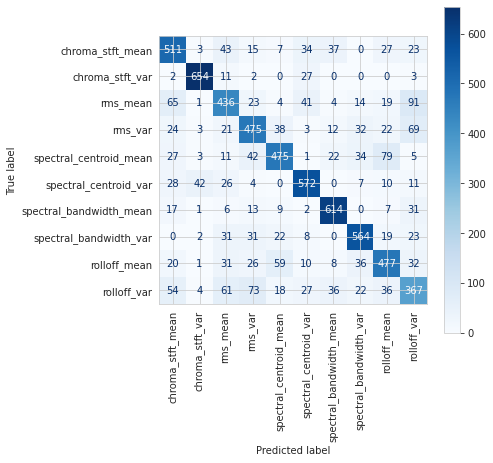

              precision    recall  f1-score   support

       blues      0.683     0.730     0.706       700
   classical      0.916     0.936     0.926       699
     country      0.644     0.625     0.634       698
       disco      0.675     0.680     0.677       699
      hiphop      0.752     0.680     0.714       699
        jazz      0.789     0.817     0.803       700
       metal      0.838     0.877     0.857       700
         pop      0.795     0.806     0.801       700
      reggae      0.685     0.681     0.683       700
        rock      0.560     0.526     0.542       698

    accuracy                          0.736      6993
   macro avg      0.734     0.736     0.734      6993
weighted avg      0.734     0.736     0.734      6993



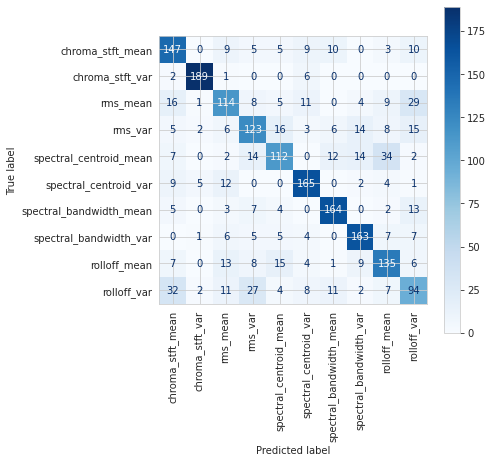

              precision    recall  f1-score   support

       blues      0.639     0.742     0.687       198
   classical      0.945     0.955     0.950       198
     country      0.644     0.579     0.610       197
       disco      0.624     0.621     0.623       198
      hiphop      0.675     0.569     0.617       197
        jazz      0.786     0.833     0.809       198
       metal      0.804     0.828     0.816       198
         pop      0.784     0.823     0.803       198
      reggae      0.646     0.682     0.663       198
        rock      0.531     0.475     0.501       198

    accuracy                          0.711      1978
   macro avg      0.708     0.711     0.708      1978
weighted avg      0.708     0.711     0.708      1978



In [57]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_train,y_train)
predictProba(lr, X_train)
predictProba(lr, X_train, dev=True)

In [58]:
pip install eli5

In [59]:

import eli5
from eli5.sklearn import PermutationImportance

In [60]:
perm = PermutationImportance(lr, random_state=seed).fit(X_train, y_train, n_iter=10)
print("Feature Importances using Permutation Importance")
eli5.show_weights(perm, feature_names = X_dev.columns.tolist())

Feature Importances using Permutation Importance


Weight,Feature
0.1722 ± 0.0118,spectral_centroid_mean
0.1473 ± 0.0085,spectral_bandwidth_mean
0.1452 ± 0.0094,mfcc1_mean
0.1366 ± 0.0086,rolloff_mean
0.1268 ± 0.0072,zero_crossing_rate_mean
0.1026 ± 0.0036,perceptr_var
0.0961 ± 0.0048,mfcc3_mean
0.0865 ± 0.0046,rms_mean
0.0859 ± 0.0025,chroma_stft_mean
0.0786 ± 0.0068,mfcc2_mean


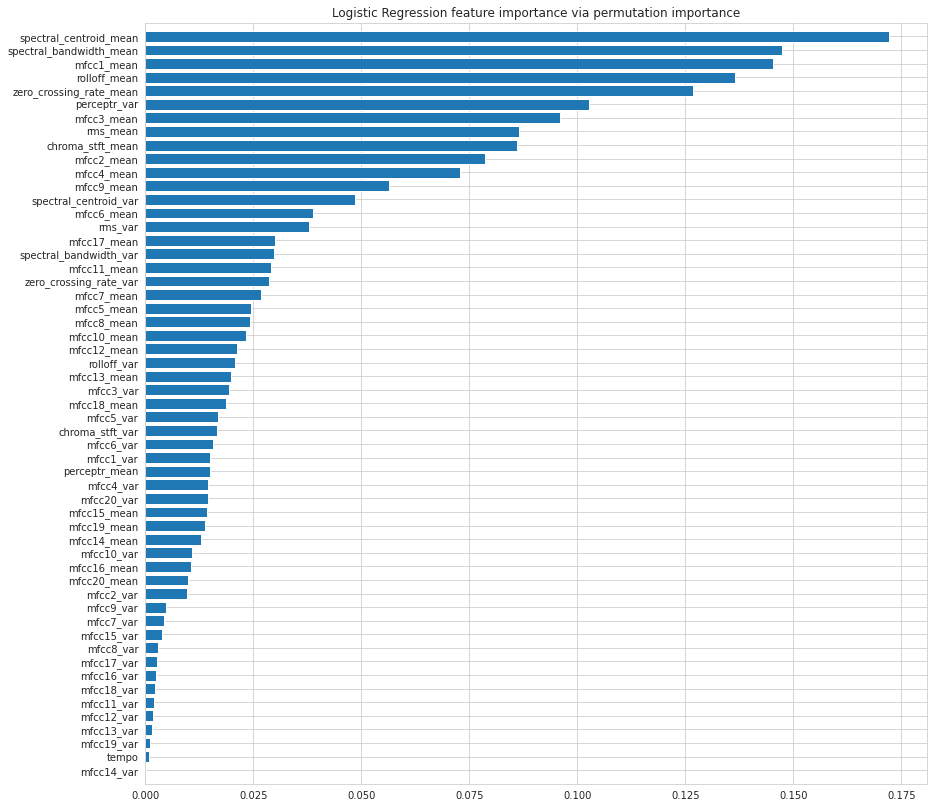

In [61]:
# plot the permutation importances
perm_indices = np.argsort(perm.feature_importances_)[::-1]
perm_features = [X_dev.columns.tolist()[xx] for xx in perm_indices]
plt.figure(figsize=(14, 14))
plt.title("Logistic Regression feature importance via permutation importance")
plt.barh(range(X_dev.shape[1]), perm.feature_importances_[perm_indices])
plt.yticks(range(X_dev.shape[1]), perm_features)
plt.ylim([X_dev.shape[1], -1])
plt.show()

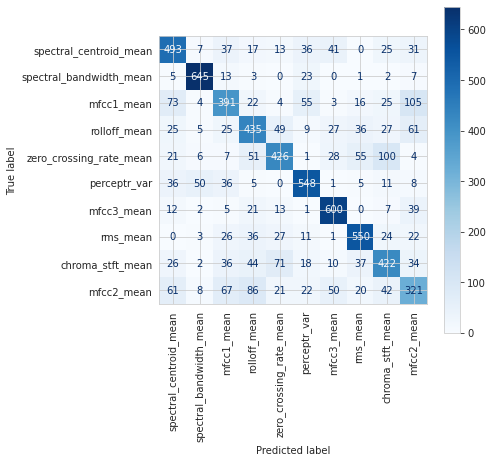

              precision    recall  f1-score   support

       blues      0.656     0.704     0.679       700
   classical      0.881     0.923     0.901       699
     country      0.608     0.560     0.583       698
       disco      0.604     0.622     0.613       699
      hiphop      0.683     0.609     0.644       699
        jazz      0.757     0.783     0.770       700
       metal      0.788     0.857     0.821       700
         pop      0.764     0.786     0.775       700
      reggae      0.616     0.603     0.609       700
        rock      0.508     0.460     0.483       698

    accuracy                          0.691      6993
   macro avg      0.686     0.691     0.688      6993
weighted avg      0.687     0.691     0.688      6993



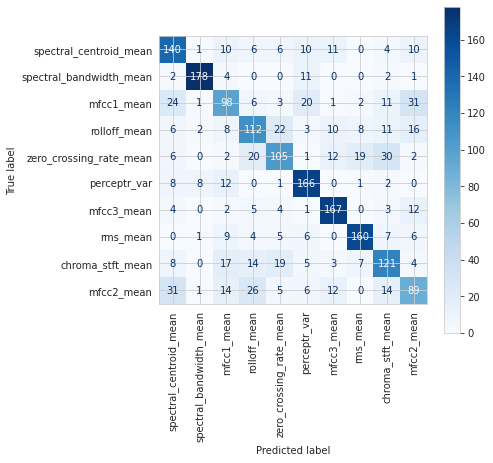

              precision    recall  f1-score   support

       blues      0.611     0.707     0.656       198
   classical      0.927     0.899     0.913       198
     country      0.557     0.497     0.525       197
       disco      0.580     0.566     0.573       198
      hiphop      0.618     0.533     0.572       197
        jazz      0.725     0.838     0.778       198
       metal      0.773     0.843     0.807       198
         pop      0.812     0.808     0.810       198
      reggae      0.590     0.611     0.600       198
        rock      0.520     0.449     0.482       198

    accuracy                          0.675      1978
   macro avg      0.671     0.675     0.672      1978
weighted avg      0.671     0.675     0.672      1978



In [62]:
# build model using perm selected top 30 features
lr = LogisticRegression()
X_train_perm = X_train[perm_features[:30]]
X_train_rfe = X_train_perm
lr.fit(X_train_perm,y_train)
predictProba(lr, X_train_perm)
predictProba(lr, X_train_perm, dev=True)


In [63]:
#y_pred_X = cbc.predict(X_test[X_train_rfe.columns])
#print(skm.classification_report(y_test, y_pred_X, digits=3))
#print("CatBoost Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

In [64]:

from sklearn import svm 

In [76]:
from sklearn.svm import SVC # "Support vector classifier"  
classifier = SVC(kernel='linear', random_state=seed)  
classifier.fit(X_train_rfe, y_train)  
#predictProba(classifier, X_train_rfe)
import pickle

pickle.dump(classifier, open('SVM.pkl','wb'))

In [68]:
audio_fp = '/content/drive/MyDrive/MGC/Data/genres_original/blues/blues.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)
audio_data = audio_data[:661500]
collection = np.split(audio_data,10)
audio_data = collection[0]

In [69]:

d = librosa.feature.mfcc(np.array(audio_data).flatten(),sr=22050 , n_mfcc = 20) #36565
d_var = d.var(axis=1).tolist()
d_mean = d.mean(axis=1).tolist()
test_data = []#[d_var + d_mean]
for i in range(20):
  test_data.append(d_mean[i])
  test_data.append(d_var[i])
mfcc_names=[]
for i in range(1,21):
  mfcc_str = "mfcc"+str(i)+"_mean"
  mfcc_names.append(mfcc_str)
  mfcc_str = "mfcc"+str(i)+"_var"
  mfcc_names.append(mfcc_str)
test_frame = pd.DataFrame([test_data], columns = mfcc_names)
test_data = []
mfcc_names=[]
#chroma
S = np.abs(librosa.stft(audio_data, n_fft=4096))**2
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
#chroma_stft_mean
chroma_mean = round(np.mean(chroma),6)
test_data.append(chroma_mean)
#chrome_stft_var
chroma_var = round(np.var(chroma),6)
test_data.append(chroma_var)
#chroma_label
mfcc_names.append("chroma_stft_mean")
mfcc_names.append("chroma_stft_var")

#rms
rms = librosa.feature.rms(y=audio_data)
#rms_mean
rms_mean = round(np.mean(rms),6)
test_data.append(rms_mean)
#rms_var
rms_var = round(np.var(rms),6)
test_data.append(rms_var)
#rms_label
mfcc_names.append("rms_mean")
mfcc_names.append("rms_var")

#spectral_centroid
cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
#spectral_centroid_mean
sc_mean = round(np.mean(cent),6)
test_data.append(sc_mean)
#spectral_centroid_var
sc_var = round(np.var(cent),6)
test_data.append(sc_var)
#sc_label
mfcc_names.append("spectral_centroid_mean")
mfcc_names.append("spectral_centroid_var")

#spectral_bandwidth
spec_bw = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
#spectral_bandwidth_mean
spec_bw_mean = round(np.mean(spec_bw),6)
test_data.append(spec_bw_mean)
#spectral_bandwidth_var
spec_bw_var = round(np.var(spec_bw),6)
test_data.append(spec_bw_var)
#sb_label
mfcc_names.append("spectral_bandwidth_mean")
mfcc_names.append("spectral_bandwidth_var")

#rolloff
rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)
#rolloff_mean
rolloff_mean = round(np.mean(rolloff),6)
test_data.append(rolloff_mean)
#rolloff_var
rolloff_var = round(np.var(rolloff),6)
test_data.append(rolloff_var)
#rolloff_label
mfcc_names.append("rolloff_mean")
mfcc_names.append("rolloff_var")

#zero_crossing_rate
zcr = librosa.feature.zero_crossing_rate(audio_data)
#zero_crossing_rate_mean
zcr_mean = round(np.mean(zcr),6)
test_data.append(zcr_mean)
#zero_crossing_rate_var
zcr_var = round(np.var(zcr),6)
test_data.append(zcr_var)
#zero_crossing_rate_label
mfcc_names.append("zero_crossing_rate_mean")
mfcc_names.append("zero_crossing_rate_var")

#harmony
y = librosa.effects.harmonic(audio_data)
harmony = librosa.feature.tonnetz(y=y, sr=sr)
#harmony_mean
harmony_mean = round(np.mean(harmony),6)
test_data.append(harmony_mean) 
#harmony_var
harmony_var = round(np.var(harmony),6)
test_data.append(harmony_var)
#harmony_label
mfcc_names.append("harmony_mean")
mfcc_names.append("harmony_var")

#perceptr_mean
#perceptr_var


#tempo
hop_length = 512
oenv = librosa.onset.onset_strength(y=audio_data, sr=sr, hop_length=hop_length)
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                          hop_length=hop_length)[0]

tempo = round(tempo,6)
test_data.append(tempo)
#tempo_label
mfcc_names.append("tempo")
d_var = d.var(axis=1).tolist()
d_mean = d.mean(axis=1).tolist()
#test_data = []#[d_var + d_mean]
for i in range(20):
  test_data.append(d_mean[i])
  test_data.append(d_var[i])
for i in range(1,21):
  mfcc_str = "mfcc"+str(i)+"_mean"
  mfcc_names.append(mfcc_str)
  mfcc_str = "mfcc"+str(i)+"_var"
  mfcc_names.append(mfcc_str)


test_frame = pd.DataFrame([test_data], columns = mfcc_names)
testing_frame = pd.DataFrame(scaler.transform(test_frame), columns=X_train.columns)
shorter_testing_frame = testing_frame[perm_features[:30]]



shorter_testing_frame.count
  

<bound method DataFrame.count of    spectral_centroid_mean  spectral_bandwidth_mean  ...  mfcc5_var  chroma_stft_var
0               -0.571196                -0.493776  ...   0.074582         0.494271

[1 rows x 30 columns]>

In [70]:
val=1
while(val<=9):
  audio_data = collection[val]
  d = librosa.feature.mfcc(np.array(audio_data).flatten(),sr=22050 , n_mfcc = 20) #36565
  d_var = d.var(axis=1).tolist()
  d_mean = d.mean(axis=1).tolist()
  test_data = []#[d_var + d_mean]
  for i in range(20):
    test_data.append(d_mean[i])
    test_data.append(d_var[i])
  mfcc_names=[]
  for i in range(1,21):
    mfcc_str = "mfcc"+str(i)+"_mean"
    mfcc_names.append(mfcc_str)
    mfcc_str = "mfcc"+str(i)+"_var"
    mfcc_names.append(mfcc_str)
  test_frame = pd.DataFrame([test_data], columns = mfcc_names)
  test_data = []
  mfcc_names=[]
  #chroma
  S = np.abs(librosa.stft(audio_data, n_fft=4096))**2
  chroma = librosa.feature.chroma_stft(S=S, sr=sr)
  #chroma_stft_mean
  chroma_mean = round(np.mean(chroma),6)
  test_data.append(chroma_mean)
  #chrome_stft_var
  chroma_var = round(np.var(chroma),6)
  test_data.append(chroma_var)
  #chroma_label
  mfcc_names.append("chroma_stft_mean")
  mfcc_names.append("chroma_stft_var")

  #rms
  rms = librosa.feature.rms(y=audio_data)
  #rms_mean
  rms_mean = round(np.mean(rms),6)
  test_data.append(rms_mean)
  #rms_var
  rms_var = round(np.var(rms),6)
  test_data.append(rms_var)
  #rms_label
  mfcc_names.append("rms_mean")
  mfcc_names.append("rms_var")

  #spectral_centroid
  cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
  #spectral_centroid_mean
  sc_mean = round(np.mean(cent),6)
  test_data.append(sc_mean)
  #spectral_centroid_var
  sc_var = round(np.var(cent),6)
  test_data.append(sc_var)
  #sc_label
  mfcc_names.append("spectral_centroid_mean")
  mfcc_names.append("spectral_centroid_var")

  #spectral_bandwidth
  spec_bw = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
  #spectral_bandwidth_mean
  spec_bw_mean = round(np.mean(spec_bw),6)
  test_data.append(spec_bw_mean)
  #spectral_bandwidth_var
  spec_bw_var = round(np.var(spec_bw),6)
  test_data.append(spec_bw_var)
  #sb_label
  mfcc_names.append("spectral_bandwidth_mean")
  mfcc_names.append("spectral_bandwidth_var")

  #rolloff
  rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)
  #rolloff_mean
  rolloff_mean = round(np.mean(rolloff),6)
  test_data.append(rolloff_mean)
  #rolloff_var
  rolloff_var = round(np.var(rolloff),6)
  test_data.append(rolloff_var)
  #rolloff_label
  mfcc_names.append("rolloff_mean")
  mfcc_names.append("rolloff_var")

  #zero_crossing_rate
  zcr = librosa.feature.zero_crossing_rate(audio_data)
  #zero_crossing_rate_mean
  zcr_mean = round(np.mean(zcr),6)
  test_data.append(zcr_mean)
  #zero_crossing_rate_var
  zcr_var = round(np.var(zcr),6)
  test_data.append(zcr_var)
  #zero_crossing_rate_label
  mfcc_names.append("zero_crossing_rate_mean")
  mfcc_names.append("zero_crossing_rate_var")

  #harmony
  y = librosa.effects.harmonic(audio_data)
  harmony = librosa.feature.tonnetz(y=y, sr=sr)
  #harmony_mean
  harmony_mean = round(np.mean(harmony),6)
  test_data.append(harmony_mean) 
  #harmony_var
  harmony_var = round(np.var(harmony),6)
  test_data.append(harmony_var)
  #harmony_label
  mfcc_names.append("harmony_mean")
  mfcc_names.append("harmony_var")

  #perceptr_mean
  #perceptr_var


  #tempo
  hop_length = 512
  oenv = librosa.onset.onset_strength(y=audio_data, sr=sr, hop_length=hop_length)
  tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                            hop_length=hop_length)[0]

  tempo = round(tempo,6)
  test_data.append(tempo)
  #tempo_label
  mfcc_names.append("tempo")
  d_var = d.var(axis=1).tolist()
  d_mean = d.mean(axis=1).tolist()
  #test_data = []#[d_var + d_mean]
  for i in range(20):
    test_data.append(d_mean[i])
    test_data.append(d_var[i])
  for i in range(1,21):
    mfcc_str = "mfcc"+str(i)+"_mean"
    mfcc_names.append(mfcc_str)
    mfcc_str = "mfcc"+str(i)+"_var"
    mfcc_names.append(mfcc_str)


  test_frame2 = pd.DataFrame([test_data], columns = mfcc_names)
  testing_frame2 = pd.DataFrame(scaler.transform(test_frame2), columns=X_train.columns)
  shorter_testing_frame2 = testing_frame2[perm_features[:30]]
  df_test = pd.concat([shorter_testing_frame, shorter_testing_frame2])
  shorter_testing_frame = df_test
  val+=1

df_test.count

<bound method DataFrame.count of    spectral_centroid_mean  spectral_bandwidth_mean  ...  mfcc5_var  chroma_stft_var
0               -0.571196                -0.493776  ...   0.074582         0.494271
0               -0.513625                -0.426737  ...  -0.062162        -0.129097
0               -0.550592                -0.287350  ...  -0.174432         0.266937
0               -0.730029                -0.518625  ...  -0.003438        -0.179898
0               -0.762451                -0.538369  ...  -0.376037        -0.007492
0               -0.273970                -0.162958  ...  -0.271844         0.504748
0               -0.318170                -0.175173  ...  -0.173959         0.574071
0               -0.668097                -0.483370  ...   0.426043         0.425267
0               -0.607060                -0.649655  ...   0.307835         1.296394
0               -0.583787                -0.675073  ...  -0.127414        -0.725371

[10 rows x 30 columns]>

In [71]:
#df_test.drop(df_test.index, inplace=True)


In [72]:
from collections import Counter
result_list=[]
#models = {'Catboost':cbc, 'XGBoost':xgbc, 'Gradient Boosting':gbc, 'AdaBoost':abc, 'Random Forest':rfc, 'Linear Regression':lr, 'KNN':cls}
models = {'SVM':classifier}
key_list = list(models.keys())
val_list = list(models.values())
 



for model in models.values():
  position = val_list.index(model)
  for i in range(10):
    test = model.predict(df_test[i:(i+1)])
    result_list.append(test)
  t = max(result_list, key = result_list.count)

  
  if t== [[0]] or t ==[['blues']]:
    genre_detected = 'blues'
  elif t== [[1]] or t==[['pop']]:
    genre_detected = 'pop'
  elif t== [[2]] or t==[['jazz']]:
    genre_detected = 'jazz'
  elif t== [[3]] or t==[['reggae']]:
    genre_detected = 'reggae'
  elif t== [[4]] or t==[['metal']]:
    genre_detected = 'metal'
  elif t== [[5]] or t==[['disco']]:
    genre_detected = 'disco'
  elif t== [[6]] or t==[['classical']]:
    genre_detected = 'classical'
  elif t== [[7]] or t==[['hiphop']]:
    genre_detected = 'hiphop'
  elif t== [[8]] or t==[['rock']]:
   genre_detected = 'rock'
  else:
    genre_detected = 'country'
  print("The tested genre with {} model is:  {}".format(key_list[position], genre_detected))


The tested genre with SVM model is:  blues
